In [8]:
from os import mkdir
from os.path import exists, join
import itertools
from functools import partial

import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import hilbert
from scipy.stats import pearsonr, differential_entropy

from tqdm import tqdm

import mne

In [9]:
def get_bands_entropy(df, bands=('alpha', 'beta', 'gamma', 'theta'), sfreq=125., nperseg=1024):
    channels = df.columns

    feats = {}

    for ch in channels:
        freqs, times,psds = signal.stft(df[ch],sfreq)
        #freqs, psds = signal.welch(df[ch], sfreq, nperseg=nperseg)
        psd_df = pd.DataFrame(data={'freqs': freqs, 'psds': np.abs(psds).tolist()})
        for band in bands:
            feats['entropy_' + get_col_name('bands', band, ch)]=differential_entropy(np.concatenate(psd_df.loc[
                    (psd_df['freqs'] >= band_bounds[band][0]) &
                    (psd_df['freqs'] <= band_bounds[band][1]),
                    'psds'].to_numpy()))


    return feats

In [10]:
def get_bands_feats(df, bands=('alpha', 'beta'), sfreq=125., nperseg=1024):

    channels = df.columns

    feats = {}

    for ch in channels:
        freqs, psds = signal.welch(df[ch], sfreq, nperseg=nperseg)
        psd_df = pd.DataFrame(data={'freqs': freqs, 'psds': psds})
        total = psd_df['psds'].sum()
        for band in bands:
            feats['feats_' + get_col_name('bands', band, ch)] = (
                psd_df.loc[
                    (psd_df['freqs'] >= band_bounds[band][0]) &
                    (psd_df['freqs'] <= band_bounds[band][1]),
                    'psds']
                .sum()
                / total
            )
    return feats

In [11]:
def get_filter(sfreq=125., band='alpha'):

    f_low_lb = band_bounds[band][0] - 1
    f_low_ub = band_bounds[band][0]
    f_high_lb = band_bounds[band][1]
    f_high_ub = band_bounds[band][1] + 1

    nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate

    freq = [0., f_low_lb, f_low_ub, f_high_lb, f_high_ub, nyq]
    gain = [0, 0, 1, 1, 0, 0]
    n = int(round(1 * sfreq)) + 1

    filt = signal.firwin2(n, freq, gain, nyq=nyq)

    return filt

In [12]:
def get_envelope_feats(df, sfreq=125., band='alpha'):

    electrodes = df.columns

    df = df.copy()
    new_df = pd.DataFrame()
    if band is not None:
        filt = get_filter(sfreq, band)
    else:
        filt = None

    for el in electrodes:
        sig = df[el]
        if filt is not None:
            sig = np.convolve(filt, df[el], 'valid')
        sig = hilbert(sig)
        sig = np.abs(sig)
        new_df[el + '_env'] = sig

    d = {}

    idx_electrodes_dict = {i: e for i, e in enumerate(electrodes)}

    for idx_1, idx_2 in itertools.combinations(range(len(electrodes)), 2):
        el_1 = idx_electrodes_dict[idx_1]
        el_2 = idx_electrodes_dict[idx_2]
        series_1 = new_df[el_1 + '_env']
        series_2 = new_df[el_2 + '_env']
        d[get_col_name('env', band, el_1, el_2)] = pearsonr(series_1, series_2)[0]

    return d


In [13]:
def get_col_name(method, band, ch_1, ch_2=None):
    band_name = 'nofilt' if band is None else band
    s = method + '_' + band_name + '_' + ch_1
    if ch_2:
        s += '_' + ch_2
    return s

In [14]:
band_bounds = {
    'theta' : [4, 8],
    'alpha': [8, 13],
    'beta': [13, 30],
    'gamma': [30, 45],
    '4_6': [2, 4],
    '6_8': [2, 4],
    '8_10': [2, 4],
    '10_12': [2, 4],
}

In [38]:
# !ls data_np_4s/kz_clean/health

In [15]:
x = np.load('data_np_4s/kz_clean/health/clean_F122_patch_1.npy')

In [16]:
import glob

In [17]:
glob.iglob('data_np_4s/kz_clean/health/*')

<generator object _iglob at 0x7f881f774660>

In [18]:
columns = ['Fp1', 'Fp2', 'Fpz', 'F3', 'F4', 'Fz', 'C3', 'C4','Cz', 'P3', 'P4', 'Pz', '01', '02', '0z', 'F7', 
           'F8', 'T3', 'T4','T5', 'T6']
df = pd.DataFrame(x, columns = columns)

In [19]:
df

,Fp1,Fp2,Fpz,F3,F4,Fz,C3,C4,Cz,P3,...,Pz,01,02,0z,F7,F8,T3,T4,T5,T6
0,6.952125e-08,7.546011e-08,8.106588e-08,1.982007e-08,2.384331e-08,1.634211e-08,9.759725e-09,7.434847e-09,1.389925e-08,7.320273e-09,...,4.881535e-10,5.365607e-09,-2.658817e-09,6.151263e-09,1.807484e-08,4.005425e-08,-3.641605e-08,1.303528e-07,1.803759e-08,2.797047e-09
1,-2.988986e-08,4.990671e-07,3.154754e-07,4.163796e-08,8.966985e-07,6.574839e-07,-1.433561e-07,6.808340e-07,4.080566e-07,-3.121708e-07,...,1.462997e-07,-2.379970e-07,-1.505955e-06,-7.573556e-07,-1.256397e-07,1.531535e-07,-1.046474e-07,4.666151e-07,4.969069e-07,3.119873e-07
2,-1.577898e-07,7.872464e-07,5.439277e-07,8.787124e-08,1.741753e-06,1.223889e-06,-2.774271e-07,1.314069e-06,8.065422e-07,-6.220357e-07,...,1.907419e-07,-5.496561e-07,-3.071439e-06,-1.544078e-06,-2.432009e-07,2.042745e-07,-1.156269e-07,7.325248e-07,9.823923e-07,5.535780e-07
3,-3.303383e-07,8.413103e-07,7.626787e-07,1.793513e-07,2.540104e-06,1.660959e-06,-3.738178e-07,1.873818e-06,1.209084e-06,-9.106948e-07,...,5.856462e-08,-9.829000e-07,-4.739312e-06,-2.372321e-06,-3.111585e-07,1.559853e-07,-2.634342e-08,8.803405e-07,1.476160e-06,6.781704e-07
4,-5.429800e-07,6.254393e-07,9.714353e-07,3.301056e-07,3.287720e-06,1.948298e-06,-4.155125e-07,2.338486e-06,1.607314e-06,-1.163967e-06,...,-2.807975e-07,-1.564932e-06,-6.511980e-06,-3.251740e-06,-3.113073e-07,1.228776e-08,1.815932e-07,9.007181e-07,1.971247e-06,6.672633e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4.614350e-06,1.755391e-06,5.673311e-06,4.151031e-06,-1.612129e-07,7.243283e-08,5.835543e-06,2.650803e-06,4.855030e-06,6.787271e-06,...,5.322240e-06,8.495500e-06,4.426477e-06,6.486046e-06,3.272499e-06,6.233391e-06,1.470667e-06,8.411841e-07,2.551708e-06,4.643187e-06
1996,6.250518e-06,2.250787e-06,6.313960e-06,5.374829e-06,-2.041210e-07,1.630445e-07,6.419196e-06,2.431770e-06,5.472037e-06,6.882648e-06,...,4.893856e-06,9.057773e-06,4.177304e-06,7.054514e-06,4.147083e-06,6.549401e-06,2.083343e-06,6.545205e-07,3.359868e-06,4.243805e-06
1997,7.741909e-06,2.695039e-06,6.865718e-06,6.412675e-06,-4.239591e-07,4.092197e-08,6.788675e-06,2.030795e-06,5.877217e-06,6.884004e-06,...,4.346377e-06,9.595653e-06,4.081137e-06,7.690914e-06,4.913679e-06,6.757827e-06,2.655994e-06,4.088641e-07,3.929675e-06,3.656792e-06
1998,8.980420e-06,3.007442e-06,7.289789e-06,7.201219e-06,-7.658645e-07,-2.817491e-07,6.912063e-06,1.489381e-06,6.047259e-06,6.768181e-06,...,3.700781e-06,1.003197e-05,4.117960e-06,8.330821e-06,5.529156e-06,6.863769e-06,3.166782e-06,1.364397e-07,4.234916e-06,2.913588e-06


In [20]:
def get_envelope_feats(df, sfreq=125., band='alpha'):
    electrodes = df.columns
    df = df.copy()
    new_df = pd.DataFrame()
    if band is not None:
        filt = get_filter(sfreq, band)
    else:
        filt = None

    for el in electrodes:
        sig = df[el]
        if filt is not None:
            sig = np.convolve(filt, df[el], 'valid')
            
        sig = hilbert(sig)
        sig = np.abs(sig)
        new_df[el + '_env'] = sig
    d = {}
    idx_electrodes_dict = {i: e for i, e in enumerate(electrodes)}
    for idx_1, idx_2 in itertools.combinations(range(len(electrodes)), 2):
        el_1 = idx_electrodes_dict[idx_1]
        el_2 = idx_electrodes_dict[idx_2]
        series_1 = new_df[el_1 + '_env']
        series_2 = new_df[el_2 + '_env']
        d[get_col_name('env', band, el_1, el_2)] = pearsonr(series_1, series_2)[0]

    return d

In [121]:
#Features generation

from pathlib import Path
result_data = []
columns = ['Fp1', 'Fp2', 'Fpz', 'F3', 'F4', 'Fz', 'C3', 'C4','Cz', 'P3', 'P4', 'Pz', '01', '02', '0z', 'F7', 
       'F8', 'T3', 'T4','T5', 'T6']
for pc_type in ['health', 'mdd']:
    for file in tqdm(glob.glob(f'data_np_4s/kz_clean/{pc_type}/*')):
        df = pd.DataFrame(np.load(file), columns = columns)
        data_dict = {}
        data_dict.update(get_bands_entropy(df, sfreq=500))
        data_dict.update(get_envelope_feats(df, sfreq=500, band='beta'))
        data_dict.update(get_bands_feats(df, sfreq=500,  bands=('alpha', 'beta', 'gamma', 'theta')))
        data_dict['target'] = 1 if pc_type == 'health' else 0
        data_dict['name'] = Path(file).stem 
        result_data.append(data_dict)

result = pd.DataFrame.from_dict(result_data)
result.to_csv('ml.csv')  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1855/1855 [04:52<00:00,  6.35it/s]


In [170]:
result

,entropy_bands_alpha_Fp1,entropy_bands_beta_Fp1,entropy_bands_gamma_Fp1,entropy_bands_theta_Fp1,entropy_bands_alpha_Fp2,entropy_bands_beta_Fp2,entropy_bands_gamma_Fp2,entropy_bands_theta_Fp2,entropy_bands_alpha_Fpz,entropy_bands_beta_Fpz,...,feats_bands_alpha_T5,feats_bands_beta_T5,feats_bands_gamma_T5,feats_bands_theta_T5,feats_bands_alpha_T6,feats_bands_beta_T6,feats_bands_gamma_T6,feats_bands_theta_T6,target,name
0,-13.728290,-13.624056,-15.834408,-13.225958,-13.582560,-13.593790,-15.657767,-13.125128,-13.571858,-13.568165,...,0.117739,0.151308,0.002834,0.138549,0.093583,0.078777,0.001882,0.122073,1,clean_F117_patch_43
1,-12.729169,-13.587557,-15.786211,-12.958005,-12.980654,-13.779130,-16.216976,-12.792485,-12.892763,-13.563334,...,0.223667,0.165292,0.004435,0.156241,0.512208,0.094983,0.001061,0.072389,1,clean_M163_patch_24
2,-13.163862,-13.141093,-15.270868,-13.024770,-12.755880,-12.781630,-15.052215,-12.727004,-12.919386,-13.201586,...,0.126807,0.166286,0.006457,0.255623,0.123857,0.177574,0.005008,0.264014,1,clean_F130_patch_48
3,-13.232000,-13.632697,-15.843904,-12.818745,-13.363398,-13.719045,-16.058201,-12.897723,-13.235419,-13.576650,...,0.110412,0.118039,0.002796,0.157801,0.131513,0.108960,0.001644,0.107869,1,clean_M163_patch_30
4,-13.427979,-13.784442,-15.839615,-13.062695,-13.314286,-13.630312,-15.696986,-12.802822,-13.416008,-13.680343,...,0.099580,0.127066,0.001272,0.251802,0.098100,0.132150,0.001493,0.366939,1,clean_F117_patch_57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,-13.250697,-13.442167,-15.448259,-13.094936,-13.368302,-13.873711,-15.781236,-13.171112,-13.373248,-13.565831,...,0.143541,0.165449,0.007349,0.207886,0.215887,0.209358,0.005025,0.176721,0,clean_F301_patch_21
3734,-12.372261,-13.880063,-16.271716,-12.926799,-12.350583,-13.466828,-15.793250,-12.949717,-12.257248,-13.665149,...,0.415751,0.182561,0.001200,0.193374,0.453534,0.195110,0.001092,0.246415,0,clean_F340_patch_27
3735,-13.052378,-13.453129,-14.886145,-12.645474,-12.971250,-13.556199,-14.555204,-12.710518,-12.848734,-13.149385,...,0.249514,0.167104,0.006399,0.187643,0.332443,0.131635,0.006817,0.122920,0,clean_M505_patch_45
3736,-13.176960,-13.163782,-14.755755,-12.766655,-13.137102,-13.208989,-14.831426,-12.947939,-12.948222,-13.151560,...,0.498578,0.237758,0.012850,0.079006,0.508698,0.258366,0.006441,0.064587,0,clean_M511_patch_9


In [ ]:
from collections import OrderedDict

In [171]:
file = np.load('valid_files.npy', allow_pickle=True).item()
valid_data = file['health'] + file['mdd']
valid_data = list(map(lambda x: Path(x).stem, valid_data))

In [172]:
masks = ['entropy_*', 'env_*', 'feats_*']
filenames = ['entropy.csv', 'env.csv', 'feats.csv']
for file, mask in zip(filenames, masks):
    data = result.filter(regex=(f'{mask}|target|name'))
    data[data['name'].isin(valid_data)].to_csv(f'{file}')


In [88]:
data = []
columns = ['Fp1', 'Fp2', 'Fpz', 'F3', 'F4', 'Fz', 'C3', 'C4','Cz', 'P3', 'P4', 'Pz', '01', '02', '0z', 'F7', 
       'F8', 'T3', 'T4','T5', 'T6']
test = result.filter(regex = ('feats_*|entropy_*|target|name'))

for i in tqdm(range(1, result.shape[0])):
    row = test.iloc[i-1:i]
    name, target = test['name'].values, test['target'].values
    for column in columns:
        t = test.filter(regex = (column)).values.tolist()[0]
        t.append(name)
        t.append(target)
    data.append(t)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3737/3737 [03:38<00:00, 17.12it/s]


In [173]:
adj_path = glob.glob('clean_wcoh/kz_clean/health/*') + glob.glob('clean_wcoh/kz_clean/mdd/*')
path_to_adj_matrix_dict = {}
for file in adj_path:
    path_to_adj_matrix_dict[Path(file).stem] = file

In [221]:
from collections import OrderedDict
import os

In [223]:
patterns = ['feats_*|entropy_*|target|name', 'entropy_*|target|name', 'feats_*|target|name']
filenames = ['only_powerbands_gnn', 'only_entropy_gnn', 'power_and_entropy_gnn']
df = result[result['name'].isin(valid_data)]
columns = ['Fp1', 'Fp2', 'Fpz', 'F3', 'F4', 'Fz', 'C3', 'C4','Cz', 'P3', 'P4', 'Pz', '01', '02', '0z', 'F7', 
       'F8', 'T3', 'T4','T5', 'T6']

test_patients = set(['F117', 'F130', 'F128', 'F133', 'F135', 'F138', 'F139', 'F136',
                 'F131', 'F344', 'F504', 'F510', 'M512', 'F341', 'F337', 'F324',
                 'F308', 'F317'])

if not os.path.exists('gnn_prepared_data/'):
    os.mkdir('gnn_prepared_data')

for pattern, filename in zip(patterns, filenames):
    df_tmp = df.filter(regex = (pattern))
    train_dict, test_dict = OrderedDict(), OrderedDict()
    
    for i in tqdm(range(1, df.shape[0])):
        row = df_tmp.iloc[i-1:i]
        name, target = row['name'].values[0], row['target'].values[0]
        features = []
        
        for column in columns:
            features.append(row.filter(regex = (column)).values.tolist()[0])
            
        adj_matrix = np.load(path_to_adj_matrix_dict[name])
        patient_id = name.split('_')[1]
        if patient_id in test_patients:
            test_dict[name] = [np.array(features), target, adj_matrix]
        else:
            train_dict[name] = [np.array(features), target, adj_matrix]
    
    np.save(f'gnn_prepared_data/{filename}_train.npy', train_dict)
    np.save(f'gnn_prepared_data/{filename}_test.npy', test_dict)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2920/2920 [00:20<00:00, 143.97it/s]


In [219]:
np.save('test_full_data.npy', test_dict)

In [217]:
len(train_dict.keys())

2052

In [205]:
test_dict['clean_F117_patch_43'][2].shape

(21, 21)

In [27]:
result.filter(regex=("entropy_*"))


,entropy_bands_alpha_Fp1,entropy_bands_beta_Fp1,entropy_bands_gamma_Fp1,entropy_bands_theta_Fp1,entropy_bands_alpha_Fp2,entropy_bands_beta_Fp2,entropy_bands_gamma_Fp2,entropy_bands_theta_Fp2,entropy_bands_alpha_Fpz,entropy_bands_beta_Fpz,...,entropy_bands_gamma_T4,entropy_bands_theta_T4,entropy_bands_alpha_T5,entropy_bands_beta_T5,entropy_bands_gamma_T5,entropy_bands_theta_T5,entropy_bands_alpha_T6,entropy_bands_beta_T6,entropy_bands_gamma_T6,entropy_bands_theta_T6
0,-13.728290,-13.624056,-15.834408,-13.225958,-13.582560,-13.593790,-15.657767,-13.125128,-13.571858,-13.568165,...,-15.319275,-12.945784,-13.390705,-13.565075,-16.033698,-12.958132,-13.333594,-13.723939,-15.989141,-12.933604
1,-12.729169,-13.587557,-15.786211,-12.958005,-12.980654,-13.779130,-16.216976,-12.792485,-12.892763,-13.563334,...,-16.214498,-12.869567,-12.555712,-13.404909,-15.817064,-12.533811,-12.014382,-13.500773,-16.125088,-12.235263
2,-13.163862,-13.141093,-15.270868,-13.024770,-12.755880,-12.781630,-15.052215,-12.727004,-12.919386,-13.201586,...,-15.193126,-12.751785,-12.828866,-13.395307,-15.720462,-12.861393,-13.061351,-13.422073,-15.583154,-12.727259
3,-13.232000,-13.632697,-15.843904,-12.818745,-13.363398,-13.719045,-16.058201,-12.897723,-13.235419,-13.576650,...,-16.103883,-12.934922,-13.104434,-13.705792,-15.830321,-12.835992,-13.319804,-13.728292,-15.974730,-13.106641
4,-13.427979,-13.784442,-15.839615,-13.062695,-13.314286,-13.630312,-15.696986,-12.802822,-13.416008,-13.680343,...,-15.398717,-12.592637,-13.013987,-13.611003,-16.009145,-12.615110,-13.569824,-13.612667,-16.168686,-12.597083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,-13.250697,-13.442167,-15.448259,-13.094936,-13.368302,-13.873711,-15.781236,-13.171112,-13.373248,-13.565831,...,-15.827234,-13.064019,-12.947399,-13.440071,-15.379533,-12.643381,-13.295111,-13.698363,-15.711385,-13.045557
3734,-12.372261,-13.880063,-16.271716,-12.926799,-12.350583,-13.466828,-15.793250,-12.949717,-12.257248,-13.665149,...,-15.485816,-12.790515,-12.016533,-13.246083,-15.976623,-12.314922,-12.146306,-13.043540,-15.969205,-12.234282
3735,-13.052378,-13.453129,-14.886145,-12.645474,-12.971250,-13.556199,-14.555204,-12.710518,-12.848734,-13.149385,...,-15.338064,-13.021175,-13.131940,-13.483281,-15.381996,-13.015593,-12.856159,-13.390076,-15.241535,-12.881888
3736,-13.176960,-13.163782,-14.755755,-12.766655,-13.137102,-13.208989,-14.831426,-12.947939,-12.948222,-13.151560,...,-14.180534,-13.222959,-12.293170,-13.196578,-14.766858,-12.614780,-12.333265,-13.293981,-14.938345,-12.728761


In [77]:
result.to_csv('ml.csv')  


#### Data clearing

In [104]:
with open('tmp/health/logs.txt') as f:
    x = f.read()
    bad_files = set(map(Path, x.split('\n')))
    bad_files.remove(Path('.'))


In [110]:
!ls tmp/health

clean_F116_patch_10.npy clean_F127_patch_43.npy clean_F138_patch_26.npy
clean_F116_patch_16.npy clean_F127_patch_49.npy clean_F138_patch_29.npy
clean_F116_patch_2.npy  clean_F127_patch_5.npy  clean_F138_patch_30.npy
clean_F116_patch_22.npy clean_F127_patch_50.npy clean_F138_patch_31.npy
clean_F116_patch_25.npy clean_F127_patch_52.npy clean_F138_patch_32.npy
clean_F116_patch_26.npy clean_F127_patch_53.npy clean_F138_patch_35.npy
clean_F116_patch_27.npy clean_F127_patch_54.npy clean_F138_patch_43.npy
clean_F116_patch_28.npy clean_F127_patch_6.npy  clean_F138_patch_45.npy
clean_F116_patch_29.npy clean_F127_patch_8.npy  clean_F138_patch_46.npy
clean_F116_patch_3.npy  clean_F128_patch_10.npy clean_F138_patch_48.npy
clean_F116_patch_34.npy clean_F128_patch_12.npy clean_F138_patch_53.npy
clean_F116_patch_35.npy clean_F128_patch_15.npy clean_F138_patch_58.npy
clean_F116_patch_37.npy clean_F128_patch_19.npy clean_F138_patch_59.npy
clean_F116_patch_38.npy clean_F128_patch_21.npy clean_F138_patch

In [111]:
import os
for file in bad_files:
    if os.path.exists(f'tmp/health/{file.name}'):
        os.remove(f'tmp/health/{file.name}')

In [119]:
healty_files = glob.glob('tmp/health/*.npy')
healty_files = list(map(lambda x: Path(x).stem, healty_files))

In [123]:
rslt_df = result[result['name'].isin(healty_files)]


In [156]:
rslt_df.to_csv('embedding.csv')

In [157]:
adj = np.load('tmp/health/clean_M157_patch_43.npy')

In [158]:
import seaborn as sns

In [159]:
adj

array([[0.99173554, 0.41144215, 0.80089669, 0.44975207, 0.30194215,
        0.33872314, 0.43484298, 0.28970248, 0.61888017, 0.46597107,
        0.26414463, 0.2709876 , 0.36290496, 0.29341322, 0.30628926,
        0.90571901, 0.32430165, 0.38166529, 0.38419835, 0.68274793,
        0.27953306],
       [0.41144215, 0.99173554, 0.41054545, 0.41969421, 0.69063223,
        0.75747107, 0.44837603, 0.63833058, 0.40197934, 0.35521488,
        0.45061983, 0.57329339, 0.2911157 , 0.46328512, 0.28352893,
        0.35273554, 0.90898347, 0.38516529, 0.57862397, 0.50021901,
        0.68340496],
       [0.80089669, 0.41054545, 0.99173554, 0.57188843, 0.31142149,
        0.34732645, 0.51802893, 0.35859917, 0.74045868, 0.48740083,
        0.27799174, 0.27149174, 0.40094215, 0.3942562 , 0.35990083,
        0.74985537, 0.40794215, 0.57367355, 0.34007851, 0.86703719,
        0.33721901],
       [0.44975207, 0.41969421, 0.57188843, 0.99173554, 0.59968182,
        0.74365289, 0.56963223, 0.56281818, 0.9008512

<AxesSubplot:>

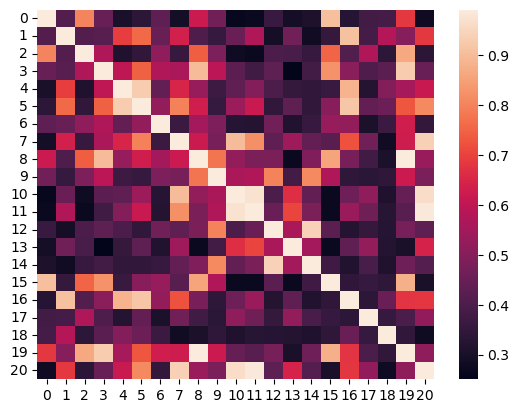

In [160]:
sns.heatmap(adj)

In [161]:
adj = np.where(adj > 0.6, 1, 0)
np.fill_diagonal(adj, 0)

In [162]:
adj

array([[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [163]:
#!pip3 install networkx

In [164]:
import networkx as nx

In [165]:
gr = nx.from_numpy_matrix(adj)

In [173]:
import matplotlib.pyplot as plt

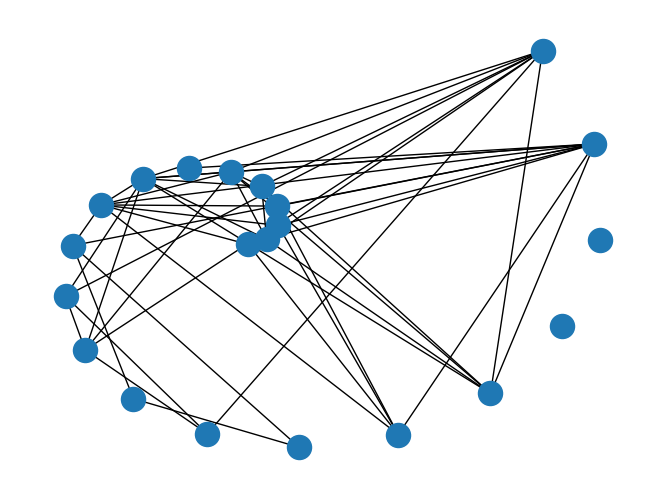

In [185]:
nx.draw(gr, cmap=plt.get_cmap('autumn_r'), pos=nx.circular_layout(gr))

In [ ]:
import pandas as pd
import torch
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from sklearn.model_selection import GroupKFold
import networkx as nx
from scipy import signal

In [192]:
class GNNDataset(InMemoryDataset):
    def __init__(self, root_raw, root_spectrum,file_path,ids, transform=None, pre_transform=None):
        self.df_part1 =pd.read_csv(file_path)
        self.root_raw =root_raw
        self.root_spectrum =root_spectrum
        self.ids=ids
        super(GNNDataset, self).__init__(root_raw, transform,pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[self.ids])
    
    
    def get_eeg_dataset(self,eeg_raw, raw_path, slice_path,slice_size =21500):
        slice_csv =slice_path / eeg_raw['slice_id']
        slice1 =pd.read_csv(slice_csv)
        file_name = raw_path / eeg_raw['fn']
        eeg =pd.read_csv(file_name).iloc[slice_size*int(eeg_raw['start']): slice_size*(int(eeg_raw['start'])+1), :]
        eeg =eeg.drop( columns =['Unnamed: 0', 'time'])
        return slice1, eeg
    
    def extract_features(self, eeg):
        df_bands =pd.DataFrame(pd.Series(get_bands_feats(eeg))).reset_index()
        df_bands["electrode"] =df_bands["index"].str.split("_").apply(lambda x :x[-1])
        df_bands["band"] =df_bands["index"].str.split("_").apply(lambda x :x[-2])
        return df_bands.pivot(index='band', columns ='electrode', values=0).reindex(columns=eeg.columns)

    def get_eeg_data(self,slice1, eeg,label, treshold = 0.5):
        columns_dict = {i : column for i, column in enumerate(eeg.columns.tolist())}
        columns_dict_inverted ={column : i for i, column in enumerate(eeg.columns.tolist())}
        X=self.extract_features(eeg).T.to_numpy()
        edges,edge_attrs =[], []
        for raw in slice1.iterrows():
            edge =raw[1]['Unnamed: 0'].split("_")
            edge[0]=columns_dict_inverted[edge[0]]
            edge[1]=columns_dict_inverted[edge[1]]
            edge_attr =raw[1]['0']
            if edge_attr>treshold:
                edges.append(edge.copy())
                edge_attrs.append(edge_attr)
        return Data(x=torch.tensor(X), edge_index=torch.tensor(np.array(edges).T),edge_attrs=edge_attrs, y=torch.tensor([label]))  

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['gnn_dataset_train3f_attr.pt','gnn_dataset_test3f_attr.pt']

    def download(self):
        pass
    
    def process(self):
        print('process')
        print(self.df_part1)
        data_list = []
        for ind in range(self.df_part1.shape[0]):
            slice1, eeg=self.get_eeg_dataset(self.df_part1.iloc[ind], Path(self.root_raw), Path(self.root_spectrum))
            data_exmp =self.get_eeg_data(slice1, eeg, self.df_part1.iloc[ind]['target'], 0.5)
            data_list.append(data_exmp)
            
        
        data, slices = self.collate(data_list)
        print(data)
        torch.save((data, slices), self.processed_paths[self.ids])

NameError: name 'InMemoryDataset' is not defined

In [ ]:
#TODO Try fully-connected weighted graph
#TODO Weighted with trashhold (current) (experiments)
#TODO With loops/without it
#TODO 